# Exercises in Clustering

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering,KMeans 
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score, adjusted_rand_score

## Exercise 1

In this exercise, we will use a bike sharing dataset. The dataset contains coordinates of bike sharing stations in New York given as longitude and latitude values.

The dataset is am example dataset from the book ["Introduction to R for Business Intelligence"](https://jgendron.github.io/com.packtpub.intro.r.bi/), Packt Publishing Ltd., 2016, by Jay Gendron. The dataset is downloadable from Github [here](https://github.com/jgendron/com.packtpub.intro.r.bi/tree/master/Chapter5-ClusteringAnalysis/data), but is also available on Moodle as "Ch5_bike_station_locations.csv".

Answer the following questions:
1. Apply K-Means clustering to the dataset. Try out different values for K and use the Elbow method to find the best (or a sensible) K.
2. Visualize the K-Means clustering result for the best K.
3. Apply Agglomerative clustering to the dataset. Draw the Dendrogram and use it to find the best (or a sensible) number of clusters.
4. Generate this number of clusters with Agglomerative clustering and visualize the clustering.
5. Apply DBSCAN clustering to the dataset. Try out different values for "eps" and "min_samples" and choose the best values. (Hint: For "eps" you probably have to try out values around 0.01.)
6. Visual the final DBSCAN clustering you decided upon in 5.
7. Calculate the Silhouette scores for the three different "best clustering" you found with the three different methods. Also use Adjusted Rand Index to compare the best ones to each other.

1. Apply K-Means clustering to the dataset. Try out different values for K and use the Elbow method to find the best (or a sensible) K.


In [2]:
df = pd.read_csv('Ch5_bike_station_locations.csv')
print(df.head())
df.describe()

    latitude  longitude
0  38.956590 -76.993437
1  38.905218 -77.001496
2  38.980858 -77.054722
3  38.902925 -76.929915
4  38.949498 -77.093620


,latitude,longitude
count,244.000000,244.000000
mean,38.914289,-77.010109
std,0.035435,0.041084
min,38.827425,-77.106502
25%,38.891574,-77.031987
50%,38.916397,-77.011474
75%,38.935887,-76.985866
max,38.987980,-76.919470


In [3]:
minMaxScaler = MinMaxScaler()
df_scaled_mm = pd.DataFrame(minMaxScaler.fit_transform(df), columns=df.columns)

In [4]:
errors = []
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_scaled_mm)
    errors.append(kmeanModel.inertia_)

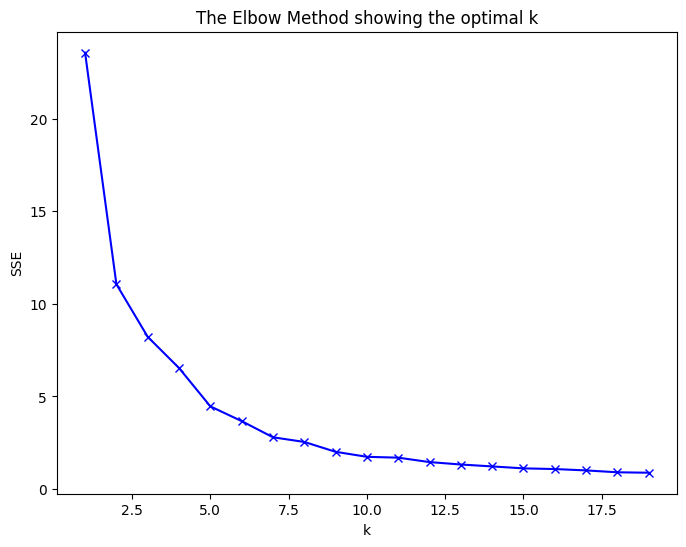

In [5]:
plt.figure(figsize=(8, 6))
plt.plot(K, errors, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [6]:
for i in range(1, len(errors)):
    print('K={0}: {1}'.format(i+1, errors[i-1] - errors[i]))

K=2: 12.502990600072305
K=3: 2.8401563821303597
K=4: 1.6834874368845547
K=5: 2.071780702455375
K=6: 0.7945560787192738
K=7: 0.8743908379069767
K=8: 0.25218725929341446
K=9: 0.5328183265504016
K=10: 0.26998566290588943
K=11: 0.045792369921710874
K=12: 0.23842590348740145
K=13: 0.13144299877118493
K=14: 0.10304042750933018
K=15: 0.10547000467292067
K=16: 0.03653331493737855
K=17: 0.07378382805987305
K=18: 0.10167777990386562
K=19: 0.0229126746826801


lets go with k=8 since this is at a balanced point

In [7]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(df_scaled_mm)

df["Cluster"] = kmeans.labels_
centroids = minMaxScaler.inverse_transform(kmeans.cluster_centers_)
print(df_scaled_mm.head())

   latitude  longitude
0  0.804491   0.604522
1  0.484526   0.561433
2  0.955641   0.276851
3  0.470244   0.944154
4  0.760319   0.068876


2. Visualize the K-Means clustering result for the best K.

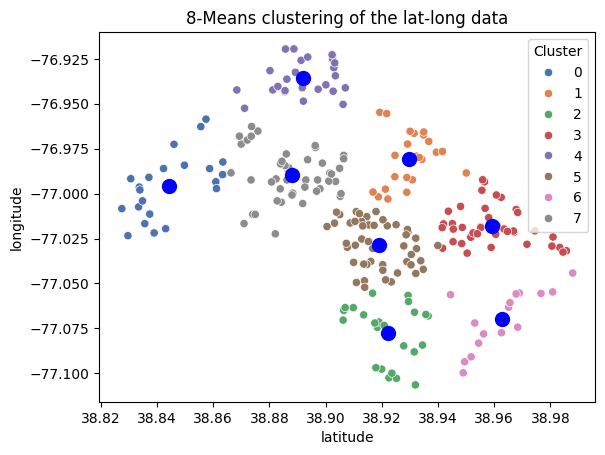

In [8]:
sns.scatterplot(data = df, x = "latitude", y = "longitude", hue = "Cluster", palette="deep")
plt.scatter(x = centroids[:,0], y = centroids[:,1], color='blue', s = 100)
plt.title("8-Means clustering of the lat-long data")
plt.show()

3. Apply Agglomerative clustering to the dataset. Draw the Dendrogram and use it to find the best (or a sensible) number of clusters.

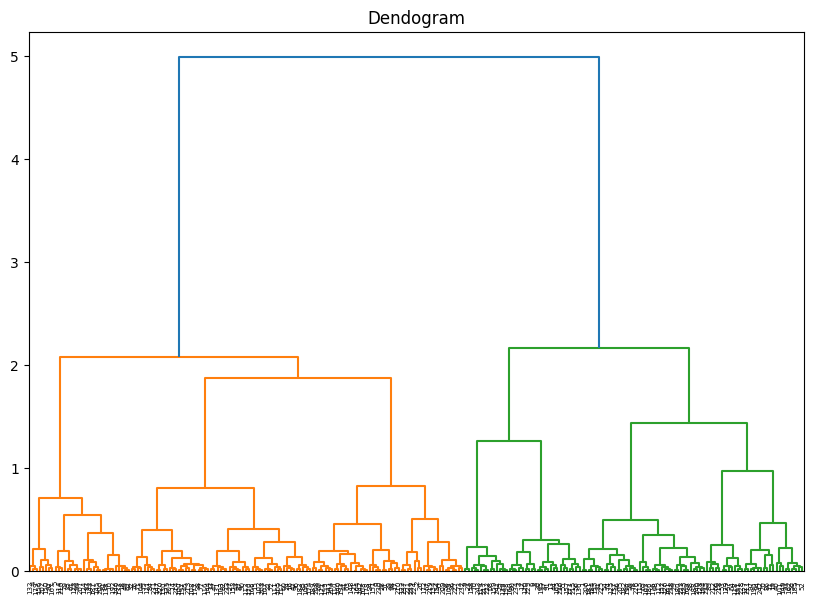

In [9]:
plt.figure(figsize=(10, 7)) 
plt.title("Dendogram")
dend = sch.dendrogram(sch.linkage(df_scaled_mm, method='ward'))

plt.show()

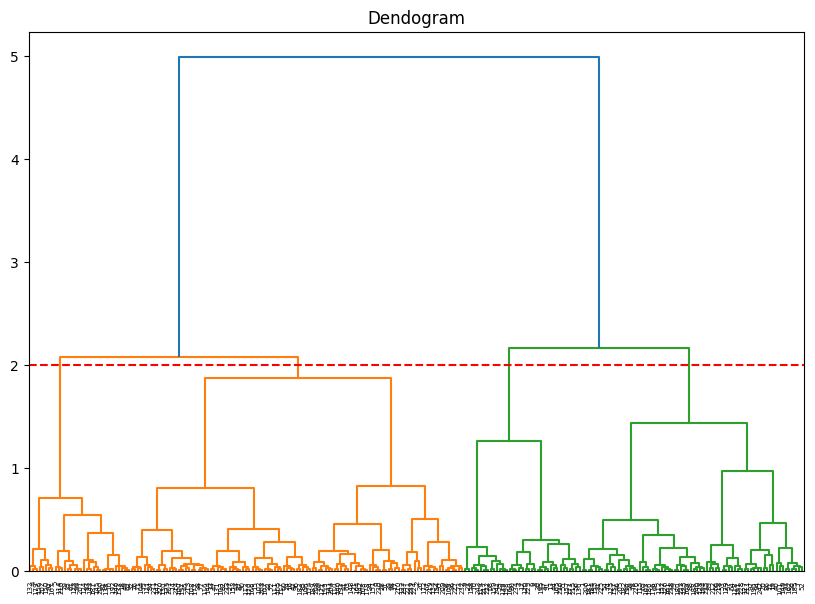

In [10]:
plt.figure(figsize=(10, 7)) 
plt.title("Dendogram")
dend = sch.dendrogram(sch.linkage(df_scaled_mm, method='ward'))
plt.axhline(y=2, color='r', linestyle='--')
plt.show()

I have decided to go with 4 clusters based on the dendrogram

4. Generate this number of clusters with Agglomerative clustering and visualize the clustering.

In [11]:
aggClustering = AgglomerativeClustering(n_clusters=4)
aggClustering.fit(df_scaled_mm)

AgglomerativeClustering(n_clusters=4)

In [12]:
df["Agglo_Cluster"] = aggClustering.labels_
df["Agglo_Cluster"]

0      0
1      1
2      0
3      2
4      3
      ..
239    0
240    1
241    2
242    1
243    2
Name: Agglo_Cluster, Length: 244, dtype: int64

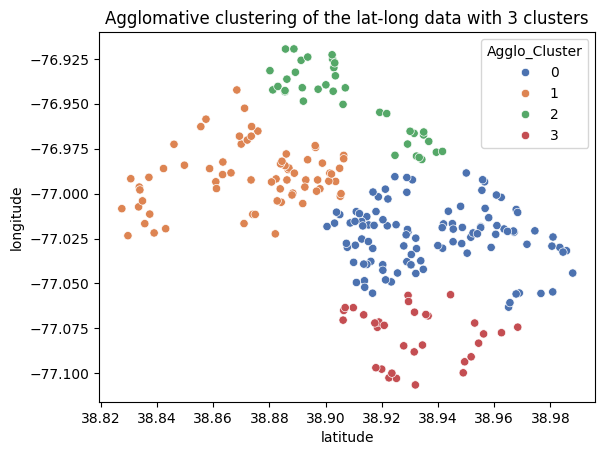

In [13]:
sns.scatterplot(data = df, x = "latitude", y = "longitude", hue = "Agglo_Cluster", palette="deep")
plt.title("Agglomative clustering of the lat-long data with 3 clusters")
plt.show()

5. Apply DBSCAN clustering to the dataset. Try out different values for "eps" and "min_samples" and choose the best values. (Hint: For "eps" you probably have to try out values around 0.01.)

In [23]:
eps_values = [0.005, 0.0075, 0.01, 0.0125, 0.015]
min_samples_values = [3, 5, 7, 10]

locations = df[["latitude", "longitude"]]

DB_results = []


for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps,min_samples=min_samples) 
        clusters_db = dbscan.fit_predict(locations)

        num_clusters = len(set(clusters_db)) - (1 if -1 in clusters_db else 0)
        num_noise = list(clusters_db).count(-1)
        
        DB_results.append({
            "eps": eps,
            "min_samples": min_samples,
            "num_clusters": num_clusters,
            "num_noise": num_noise
        })

DB_results = pd.DataFrame(DB_results)
print(DB_results)


       eps  min_samples  num_clusters  num_noise
0   0.0050            3            24        103
1   0.0050            5             7        197
2   0.0050            7             1        234
3   0.0050           10             0        244
4   0.0075            3            20         21
5   0.0075            5            12         87
6   0.0075            7             4        153
7   0.0075           10             3        213
8   0.0100            3            10         10
9   0.0100            5            10         26
10  0.0100            7             6         87
11  0.0100           10             5        126
12  0.0125            3             5          6
13  0.0125            5             6         12
14  0.0125            7             5         38
15  0.0125           10             4         69
16  0.0150            3             1          0
17  0.0150            5             3          1
18  0.0150            7             4         11
19  0.0150          

looking at this data, i can see that the best choice is eps=0.01 and min_samples = 3 since it has 10 clusters and 10 noise points. this will create very well defined clusters with minimal noise 

6. Visual the final DBSCAN clustering you decided upon in 5.

In [20]:
# Best parameters chosen
best_eps = 0.0150
best_min_samples = 5

# Train DBSCAN
dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df["DBSCAN_Cluster"] = dbscan_final.fit_predict(df[["latitude", "longitude"]])

# Show cluster counts
print(df["DBSCAN_Cluster"].value_counts())

DBSCAN_Cluster
 0    223
 1     14
 2      6
-1      1
Name: count, dtype: int64


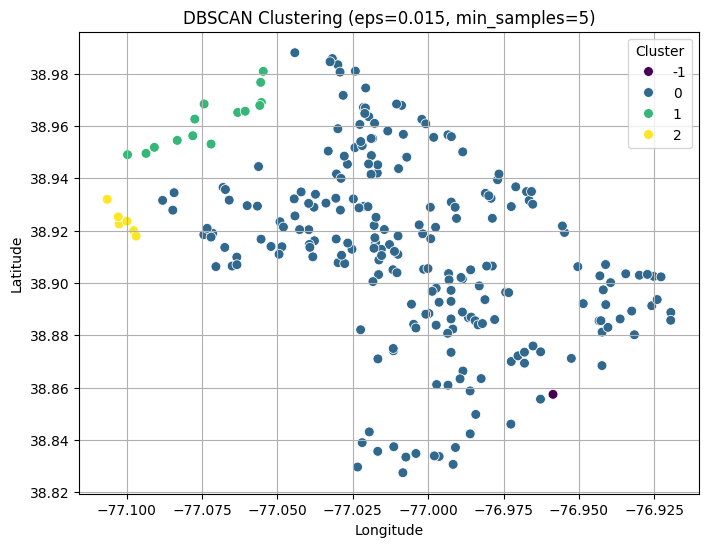

In [21]:
# Scatter plot with DBSCAN clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="longitude", y="latitude", hue="DBSCAN_Cluster", palette="viridis", s=50)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"DBSCAN Clustering (eps={best_eps}, min_samples={best_min_samples})")
plt.legend(title="Cluster")
plt.grid()
plt.show()


7. Calculate the Silhouette scores for the three different "best clustering" you found with the three different methods. Also use Adjusted Rand Index to compare the best ones to each other.

In [17]:
SilScore_df = pd.DataFrame({
    "Clustering Method": ["KMeans", "Agglomerative", "DBSCAN"], 
    "Silhouette Score": [
        silhouette_score(X=df_scaled_mm, labels=kmeans.labels_),  # KMeans
        silhouette_score(X=df_scaled_mm, labels=aggClustering.labels_),  # Agglomerative
        silhouette_score(X=df[dbscan_final.labels_ != -1], labels=dbscan_final.labels_[dbscan_final.labels_ != -1])  # Exclude noise
    ]
})
SilScore_df


,Clustering Method,Silhouette Score
0,KMeans,0.451266
1,Agglomerative,0.366738
2,DBSCAN,0.011061


i have calculated silhouette scores based on the data the models were trained on, so this means that kmeans and agglomerative clustering were calculated based on scaled data and DBSCAN was calculated based on non-scaled data. 
Still DBSCAN scored lowest, but this could also be because silhouette scores are distance based, so DBSCAN is at a disadvantage here. 

lets do an ARI to compare the clustering of the different models 


In [18]:
ARI_df = pd.DataFrame({
    "Clustering Method": ["K-Means", "Agglomerative", "DBSCAN"],
    "Compared to": ["Agglomerative", "DBSCAN", "Agglomerative"],
    "Adjusted Rand Score": [
        adjusted_rand_score(df["Cluster"], df["Agglo_Cluster"]),  # K-Means vs Agglomerative
        adjusted_rand_score(df["Cluster"], df["DBSCAN_Cluster"]),  # K-Means vs DBSCAN
        adjusted_rand_score(df["Agglo_Cluster"], df["DBSCAN_Cluster"])
    ]
})

ARI_df

,Clustering Method,Compared to,Adjusted Rand Score
0,K-Means,Agglomerative,0.490980
1,Agglomerative,DBSCAN,0.046253
2,DBSCAN,Agglomerative,0.052957


looking at the ARI, the only two methods that somewhat aggree are K-Means and Agglomerative, DBSCAN is quite different from both Agglomerative and K-means 